In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')


%load_ext autoreload
%autoreload 2

%matplotlib inline  

import matplotlib.pyplot as plt 
import numpy as np


from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import orient
from shapely.affinity import scale, rotate, translate

from PIL import Image, ImageFont, ImageDraw

from joblib import dump, load

from tqdm.autonotebook import tqdm

from shared.nbs_helpers import draw_polys, draw_clusters, InParallelWithBar
from shared.utils import np_to_shapely, shapely_to_np

/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from shared.mlt_dataset import ICDAR_MLT
from shared.coco_dataset import COCO
from shared.ubertext_dataset import UberText
from shared.synthtext_dataset import SynthText

from PIL import Image
import pandas as pd

from shapely.geometry import box, Polygon
from shared.clusters import scale_to_square, cluster_polys, cluster_polys_np
from shared.clusters import np_to_sh_cluster, sh_cluster_crop, np_cluster_crop

import string

In [3]:
sys.path.insert(0, '../pytorch-CycleGAN-and-pix2pix')

from data.base_dataset import get_params, get_transform
from options.train_options import TrainOptions
from torchvision.transforms.functional import to_tensor, to_pil_image

from data.tx_dataset import TxDataset
from data import CustomDatasetDataLoader

# dl = CustomDatasetDataLoader(opt)


from shared.nbs_helpers import build_dataset, build_dataloader



In [11]:
txds = build_dataset()

[autoreload of shared.datasets_v2 failed: Traceback (most recent call last):
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/ex

In [ ]:
txdl = build_dataloader(dataset=txds)

In [ ]:
x = next(iter(txdl))
x['A'].shape


In [16]:
a = txds[0]
a

{'A': tensor([[[-0.8118, -0.8196, -0.8275,  ..., -0.8902, -0.8824, -0.8824],
          [-0.8118, -0.8196, -0.8275,  ..., -0.8902, -0.8824, -0.8824],
          [-0.8118, -0.8196, -0.8275,  ..., -0.8902, -0.8824, -0.8824],
          ...,
          [ 0.5137,  0.5059,  0.5216,  ..., -0.1137, -0.0902, -0.1059],
          [ 0.5059,  0.5059,  0.5216,  ..., -0.1059, -0.1294, -0.1294],
          [ 0.4980,  0.4980,  0.5137,  ..., -0.0980, -0.0824, -0.0902]],
 
         [[-0.8902, -0.8980, -0.9059,  ..., -0.9216, -0.9137, -0.9137],
          [-0.8902, -0.8980, -0.9059,  ..., -0.9216, -0.9137, -0.9137],
          [-0.8902, -0.8980, -0.9059,  ..., -0.9216, -0.9137, -0.9137],
          ...,
          [ 0.1922,  0.1843,  0.1922,  ..., -0.3490, -0.3255, -0.3490],
          [ 0.2000,  0.2000,  0.1843,  ..., -0.3255, -0.3490, -0.3490],
          [ 0.1922,  0.1922,  0.1765,  ..., -0.3176, -0.3020, -0.3098]],
 
         [[-0.9608, -0.9686, -0.9765,  ..., -0.9294, -0.9216, -0.9216],
          [-0.9608, -0.

[autoreload of shared.datasets_v2 failed: Traceback (most recent call last):
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/IPython/ex

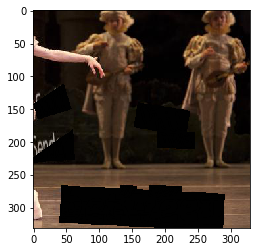

In [20]:
img_with_edges, img, img_mask, masks, patch_edges, img_path, crop = txds.base_ds[0]

plt.imshow(img_with_edges)

In [17]:
# def show_x(x): plt.imshow(x.permute(1, 2, 0))
def show_x(x): plt.imshow(x.permute(0, 2, 3, 1)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


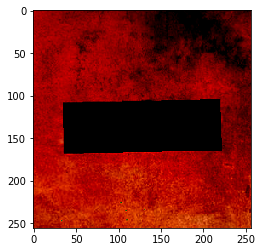

In [18]:
show_x(x['A'])

In [85]:
from shared.datasets_v2 import poly_to_crop, assamble_cluster, adjust_cluster_to_crop, bg_img_mask, adjust_buggy_crop, combine_edges_and_bg, feature

img_paths, (image_w, image_h), main_poly_sh, main_poly_id, polys_sh = txds.base_ds.load_data(0)

crop = poly_to_crop(main_poly_sh, image_w, image_h, border_size=90)
                
cluster = assamble_cluster(crop, main_poly_sh, main_poly_id, polys_sh)

cluster = adjust_cluster_to_crop(crop, cluster)

img = Image.open(img_paths['img_path'])
img = img.convert('RGB').crop(box=crop.bounds)

cluster = [shapely_to_np(poly_sh) for poly_sh in cluster]

bg_mask, masks = bg_img_mask(img.size, cluster, rectify_poly=False)
# bg_mask = 1-bg_mask

img = adjust_buggy_crop(img, *bg_mask.shape, fail_on_bad_crop=False)


edges_img = feature.canny(np.array(img.convert('L'))/255, sigma=.5) 



def combine_edges_and_bg(edges_img, bg_img, bg_mask):
    
    # n_px = 1 - text_edges.sum()/(1-bg_mask).sum()
    # print(n_px)

    edges_img = (1-edges_img) * (1 - bg_mask)
    edges_img = np.repeat(edges_img[None, ...], 3, axis=0) * 255

    
    return ((bg_img/255).transpose(2, 0, 1) * bg_mask + edges_img*255).transpose(1, 2, 0)

img_with_edges = combine_edges_and_bg(edges_img, np.array(img), bg_mask)



In [86]:
np_to_pil = lambda img: Image.fromarray((img*255).astype('uint8'))
img_with_edges, bg_mask = np_to_pil(img_with_edges), np_to_pil(bg_mask)

masks[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [48]:
bg_mask.shape

(311, 311)

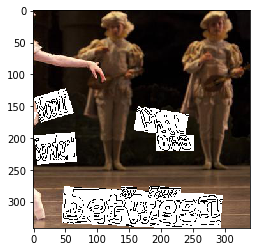

In [77]:
plt.imshow(img_with_edges)

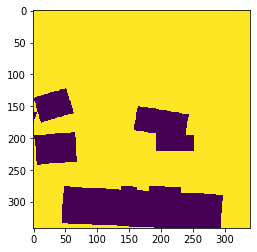

In [83]:
plt.imshow(bg_mask)

In [34]:
img = Image.open(img_paths['img_path'])
np.array(img), np.array(img).shape

(array([[[42,  5, 13],
         [41,  6, 12],
         [38,  7, 12],
         ...,
         [40,  8, 13],
         [40,  8, 13],
         [40,  8, 13]],
 
        [[42,  5, 13],
         [41,  6, 12],
         [39,  9, 11],
         ...,
         [41,  9, 14],
         [40,  8, 13],
         [40,  8, 13]],
 
        [[43,  6, 13],
         [42,  7, 13],
         [39,  9, 11],
         ...,
         [43,  8, 14],
         [43,  8, 14],
         [42,  7, 13]],
 
        ...,
 
        [[95, 70, 65],
         [92, 67, 62],
         [88, 63, 58],
         ...,
         [47, 33, 32],
         [47, 33, 32],
         [47, 33, 32]],
 
        [[73, 48, 43],
         [73, 48, 43],
         [74, 49, 44],
         ...,
         [46, 32, 31],
         [46, 32, 31],
         [45, 31, 30]],
 
        [[76, 51, 46],
         [77, 52, 47],
         [80, 55, 50],
         ...,
         [45, 31, 30],
         [45, 31, 30],
         [45, 31, 30]]], dtype=uint8), (600, 400, 3))

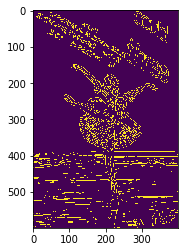

In [36]:
from skimage import feature
plt.imshow(feature.canny(np.array(img.convert('L'))/255, sigma=.5) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


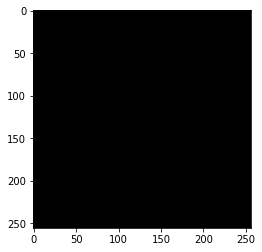

In [30]:
show_x(x['A'])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

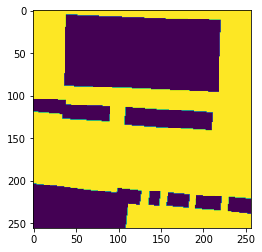

In [17]:
plt.imshow(x['mask'][0, 0])

x['mask'][0, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


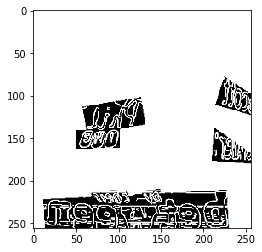

In [31]:
show_x( 1 - ( (1- x['mask']) * x['A']  ) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


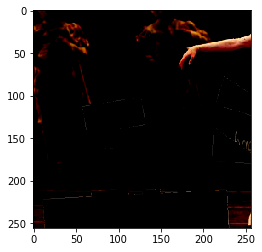

In [30]:
show_x( (x['mask'] * x['A']  ) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


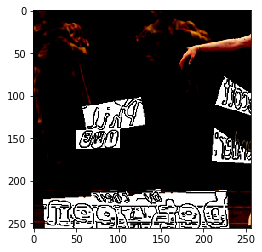

In [32]:
show_x(x['A']  )


In [56]:
from setproctitle import setproctitle

setproctitle('python10')

In [57]:
import torch

real_A = x['A']

mask = x['mask']

mask.shape, real_A.shape, ( real_A * (1 - mask) ).shape

(torch.Size([12, 1, 256, 256]),
 torch.Size([12, 3, 256, 256]),
 torch.Size([12, 3, 256, 256]))

In [64]:
mask.repeat(1, 3, 1, 1).shape

torch.Size([12, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


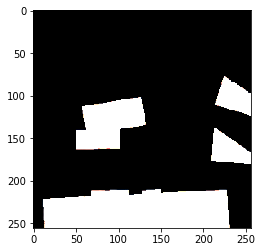

In [61]:
real_A = torch.cat([ 
        ( real_A * (1 - mask) ).sum(1).unsqueeze(1),
          real_A * mask + (1-mask)
    ], dim=1)

# ( real_A * (1 - mask) ).shape

show_x( real_A[:, :3, ...] )
# real_A.shape

# Jsynth biz

In [1]:
from PIL import Image
from pathlib import Path

In [2]:
Image.open(Path('~/data/tx/mnt/ramdisk/max/90kDICT32px/1/1/178_QUAINTEST_61657.jpg').expanduser())

p = Path('~/data/tx/mnt/ramdisk/max/90kDICT32px').expanduser()

In [8]:
list(x for x in p.iterdir() if x.is_file())

[PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/annotation.txt'),
 PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/lexicon.txt'),
 PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/imlist.txt'),
 PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/annotation_test.txt'),
 PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/annotation_train.txt'),
 PosixPath('/nfs/home/anerinovsky/data/tx/mnt/ramdisk/max/90kDICT32px/annotation_val.txt')]

In [3]:
lexicon =  (p/'lexicon.txt').read_text().split('\n')
ann_train = (p/'annotation_train.txt').read_text().split('\n')
ann_test = (p/'annotation_test.txt').read_text().split('\n')

In [5]:
set(''.join(lexicon))

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [18]:
import string

string.printable[:62]


'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [30]:
anns = ann_train
file = p / anns[0].split()[0]
_, *label, _ =  file.parts[-1].split('_')
label = '_'.join(label)
img = Image.open(file)

'Lube'

In [ ]:
class Mjsynth(Sequence):

    def __init__(self, batch_size, train=True,):
        
        self.batch_size = batch_size
        f = 'train' if train else 'test'
        self.anns = (p/f'annotation_{f}.txt').read_text().split('\n')
        
    def __len__(self):
        return math.ceil(len(self.anns) / self.batch_size)

    def __getitem__(self, idx):
        
        anns = self.anns[idx * self.batch_size:(idx + 1)*self.batch_size]
        
        for ann in anns:
            file = p / anns[0].split()[0]
            _, *label, _ =  file.parts[-1].split('_')
            label = '_'.join(label)
            img = Image.open(file)
            

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

